In [5]:
import numpy as np
import scipy as sp
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import ot
from lib.SinkhornNP import SolveOT
from lib.get_density import *
seed = np.random.SeedSequence()
gen = np.random.Generator(np.random.MT19937(seed))
use_GPU = True
if use_GPU:
    dev = torch.device('cuda')
else:
    dev = torch.device('cpu')

In [2]:
M = 100  #Number of point pair in one Batch
N = 100  #Number of Batches
S = 100  #Number of subsampling, should be smaller than M*N
std = 0.05  #Standard diviation for distance
jump = 0.3  #Distance of shift
jump_prob = 0.5  #Probability of shifting
ve = 50/(M*N)  #Sinkhorn regulariser, suggested order is O(M*N^{-1/dim})
subsample = True
EMML_itr = 10000  #Maxitr for minimisation algo (make it large when M is large)
E = 100  #resolution for output image

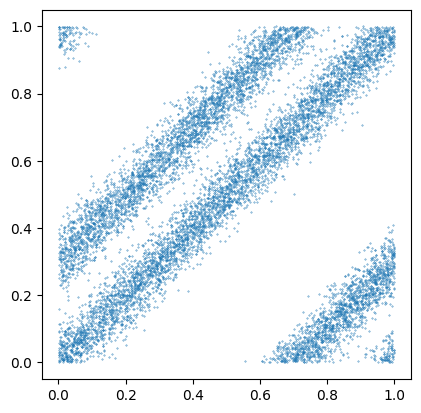

In [3]:
#Test generated samples, 
mn = M*N
x,y = sample_Gau(gen,num = mn ,std = std, shift = jump, shift_prob = jump_prob)
plt.scatter(x,y,s = .1)
_ = plt.axis('scaled')

In [6]:
#Subsample points
S1 = gen.integers(0, mn, size = S)
S2 = gen.integers(0, mn, size = S)
if (subsample):
    sx = x[S1]
    sy = y[S2]
else:
    sx = x
    sy = y
    S = mn
# Res_X = SolveOT(np.ones(mn)/mn,np.ones(S)/S,cost(x,sx),1e-9,ve,1,returnSolver = True)
# EK_x = Res_X[1].toarray() #Transport plan from mu to subsampled x points
# Res_Y = SolveOT(np.ones(mn)/mn,np.ones(S)/S,cost(y,sy),1e-9,ve,1,returnSolver = True)
# EK_y = Res_Y[1].toarray() #Transport plan from nu to subsampled y points

LX = ot.sinkhorn(torch.ones(mn, device = dev, dtype = torch.float64)/mn,
            torch.ones(S,device = dev,dtype = torch.float64)/S, cost(x,sx,dev),ve
            ,log = True,numItermax = 1000000,method = 'sinkhorn_log')
LY = ot.sinkhorn(torch.ones(mn, device = dev, dtype = torch.float64)/mn,
                torch.ones(S,device = dev,dtype = torch.float64)/S, cost(y,sy,dev),ve
                ,log = True,numItermax = 1000000,method = 'sinkhorn_log')
EK_x = LX[0]#Transport plan from nu to subsampled y points
EK_y = LY[0]#Transport plan from nu to subsampled y points



In [7]:
#EMML minimisation of cost function
rho = EMML(EK_x,EK_y,M,EMML_itr,dev = dev)
# rho = EMML(EK_x,EK_y,M,EMML_itr)


#Do kernel extension for illustration, x_e and y_e should be close to the true marginal (in this case is uniform so we take linspace) 
x_e = y_e = np.linspace(0,1,E,endpoint=False)
xpot = 1/(torch.sum(torch.exp(-cost(x_e,sx,dev)/ve + LX[1]["log_v"]),axis=1))
ypot = 1/(torch.sum(torch.exp(-cost(y_e,sy,dev)/ve + LY[1]["log_v"]),axis=1))
F_X = xpot[:,torch.newaxis]*torch.exp(-cost(x_e,sx,dev)/ve + LX[1]["log_v"])*S
F_Y = ypot[:,torch.newaxis]*torch.exp(-cost(y_e,sy,dev)/ve + LY[1]["log_v"])*S
Mat = (F_Y@rho@F_X.T).cpu()


#Do kernel extension for illustration, x_e and y_e should be close to the true marginal (in this case is uniform so we take linspace) 
# x_e = y_e = np.linspace(0,1,E,endpoint = False)
# xpot = 1/(np.sum(np.exp((-cost(x_e,sx) + Res_X[2].beta)/ve),axis=1))
# ypot = 1/(np.sum(np.exp((-cost(y_e,sy) + Res_Y[2].beta)/ve),axis=1))
# F_X = xpot[:,np.newaxis]*np.exp((-cost(x_e,sx) + Res_X[2].beta)/ve)*S
# F_Y = ypot[:,np.newaxis]*np.exp((-cost(y_e,sy) + Res_Y[2].beta)/ve)*S
# Mat = F_Y@rho@F_X.T

        
    

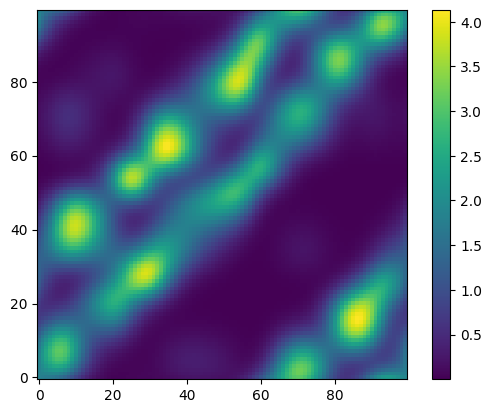

In [8]:
plt.imshow(Mat,origin = "lower")
plt.colorbar()